## Imports

In [38]:
import cv2
import cupy as cp
import numpy as np
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
from cupyx.scipy.signal import fftconvolve
from skimage.measure import manders_overlap_coeff

## Helper Functions

In [27]:
def convolve_arrays(array1: np.ndarray, array2: np.ndarray, mode='same') -> cp.ndarray:
    cupy_array1 = cp.asarray(array1)
    cupy_array2 = cp.asarray(array2)
    return fftconvolve(cupy_array1, cupy_array2, mode=mode)

In [28]:
def gaussian_filter(size, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    d = np.sqrt(x*x + y*y)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    return g / g.sum()

In [29]:
def MSE(arr1, arr2):
    mse = cp.mean((arr1 - arr2) ** 2)
    return mse

In [ ]:
def kernel_and_divide(sigma, size, le_input):
    gaussian = gaussian_filter(size, sigma)
    image_le_temp = convolve_arrays(le_input, gaussian)
    division = cp.divide(input_image_cp, image_le_temp)
    plt.imsave("amgus.jpg", cp.asnumpy(division), cmap="gray")

In [49]:
import numpy as np

def weighted_manders_overlap_coeff(image0, image1, mask=None):
    """
    Calculate the weighted Manders' overlap coefficient between two images, 
    taking pixel intensities into account.
    
    Parameters
    ----------
    image0 : (M, N) ndarray
        Image of channel A. All pixel values should be non-negative.
    image1 : (M, N) ndarray
        Image of channel B. All pixel values should be non-negative. Must have same dimensions as image0.
    mask : (M, N) ndarray of dtype bool, optional
        Only image0 and image1 pixel values within this region of interest mask are included in the calculation. 
        Must have same dimensions as image0.
    
    Returns
    -------
    wmoc : float
        Weighted Manders' Overlap Coefficient of pixel intensities between the two images.
    """
    
    if mask is not None:
        image0 = np.where(mask, image0, 0)
        image1 = np.where(mask, image1, 0)
    
    # Calculate the sum of products of corresponding pixel intensities
    numerator = np.sum(image0 * image1)
    
    # Calculate the product of the sums of pixel intensities in each image
    denominator = np.sqrt(np.sum(image0**2) * np.sum(image1**2))
    
    # Calculate the weighted Manders' overlap coefficient
    wmoc = numerator / denominator if denominator != 0 else 0
    
    return wmoc

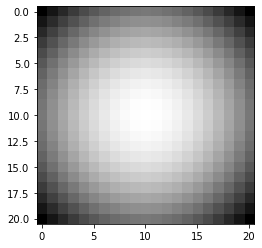

In [30]:
plt.imshow(gaussian_filter(21, 2), cmap="gray")

## Algo

In [31]:
ssim_kernel_div = 0
ssim_sigma_div = 0
ssim_best_div = -float('inf')
ssim_image_div = 0

mse_kernel_div = 0
mse_sigma_div = 0
mse_best_div = float('inf')
mse_image_div = 0

ssim_kernel_sub = 0
ssim_sigma_sub = 0
ssim_best_sub = -float('inf')
ssim_image_sub = 0

mse_kernel_sub = 0
mse_sigma_sub = 0
mse_best_sub = float('inf')
mse_image_sub = 0

In [43]:
input_image = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
target_image = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
result_image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
input_image_cp = cp.array(input_image)
target_image_cp = cp.array(target_image)

In [52]:
manders_overlap_coeff(target_image, result_image)
weighted_manders_overlap_coeff(target_image, result_image)


0.9813312388724024

In [53]:
manders_overlap_coeff(target_image, input_image)
weighted_manders_overlap_coeff(target_image, input_image)


0.986095448872319

In [37]:
for kernel_size in range(11, 55, 2):
    for sigma in np.arange(0.1, 5, 0.1):
        gaussian = cp.asarray(gaussian_filter(kernel_size, sigma))
        image_le_temp = fftconvolve(input_image_cp, gaussian, mode='same')

        # Normalize subtraction result
        substract = cp.subtract(input_image_cp, image_le_temp)
        substract_min, substract_max = cp.min(substract), cp.max(substract)
        substract_normalized = 0.7 * (substract - substract_min) / (substract_max - substract_min)

        # Normalize division result
        division = cp.divide(input_image_cp, image_le_temp)
        division_min, division_max = cp.min(division), cp.max(division)
        division_normalized = 0.7 * (division - division_min) / (division_max - division_min)

        ssim_value_div = ssim(cp.asnumpy(division_normalized), cp.asnumpy(target_image_cp), data_range=0.7)
        mse_value_div = MSE(division_normalized, target_image_cp)
        
        ssim_value_sub = ssim(cp.asnumpy(substract_normalized), cp.asnumpy(target_image_cp), data_range=0.7)
        mse_value_sub = MSE(substract_normalized, target_image_cp)

        if ssim_value_div > ssim_best_div:
            ssim_kernel, ssim_sigma, ssim_best = kernel_size, sigma, ssim_value_div
            print(f"New best SSIM (div): {ssim_value_div:.4f} (kernel: {kernel_size}, sigma: {sigma:.2f})")

        if mse_value_div < mse_best_div:
            mse_kernel, mse_sigma, mse_best = kernel_size, sigma, mse_value_div
            print(f"New best MSE (div): {mse_value_div:.4f} (kernel: {kernel_size}, sigma: {sigma:.2f})")

        if ssim_value_sub > ssim_best_sub:
            ssim_kernel, ssim_sigma, ssim_best = kernel_size, sigma, ssim_value_sub
            print(f"New best SSIM (sub): {ssim_value_sub:.4f} (kernel: {kernel_size}, sigma: {sigma:.2f})")

        if mse_value_sub < mse_best_sub:
            mse_kernel, mse_sigma, mse_best = kernel_size, sigma, mse_value_sub
            print(f"New best MSE (sub): {mse_value_sub:.4f} (kernel: {kernel_size}, sigma: {sigma:.2f})")

print(f"Final best SSIM: {ssim_best:.4f} (kernel: {ssim_kernel}, sigma: {ssim_sigma:.2f})")
print(f"Final best MSE: {mse_best:.4f} (kernel: {mse_kernel}, sigma: {mse_sigma:.2f})")

New best SSIM (div): 0.0802 (kernel: 11, sigma: 0.10)
New best MSE (div): 0.3190 (kernel: 11, sigma: 0.10)
New best SSIM (sub): 0.0771 (kernel: 11, sigma: 0.10)
New best MSE (sub): 0.3386 (kernel: 11, sigma: 0.10)
New best SSIM (div): 0.0591 (kernel: 11, sigma: 0.20)
New best MSE (div): 0.3614 (kernel: 11, sigma: 0.20)
New best SSIM (sub): 0.0961 (kernel: 11, sigma: 0.20)
New best MSE (sub): 0.3334 (kernel: 11, sigma: 0.20)
New best SSIM (div): 0.0596 (kernel: 11, sigma: 0.30)
New best MSE (div): 0.3644 (kernel: 11, sigma: 0.30)
New best SSIM (sub): 0.1390 (kernel: 11, sigma: 0.30)
New best MSE (sub): 0.2882 (kernel: 11, sigma: 0.30)
New best SSIM (div): 0.0593 (kernel: 11, sigma: 0.40)
New best MSE (div): 0.3677 (kernel: 11, sigma: 0.40)
New best SSIM (sub): 0.1572 (kernel: 11, sigma: 0.40)
New best MSE (sub): 0.2699 (kernel: 11, sigma: 0.40)
New best SSIM (div): 0.0607 (kernel: 11, sigma: 0.50)
New best MSE (div): 0.3651 (kernel: 11, sigma: 0.50)
New best SSIM (sub): 0.1597 (kernel: 

KeyboardInterrupt: 

In [ ]:
mendlers = 0

for kernel_size in range(11, 55, 2):
    for sigma in np.arange(0.1, 5, 0.1):
        gaussian = cp.asarray(gaussian_filter(kernel_size, sigma))
        image_le_temp = fftconvolve(input_image_cp, gaussian, mode='same')

        # Normalize subtraction result
        substract = cp.subtract(input_image_cp, image_le_temp)
        substract_min, substract_max = cp.min(substract), cp.max(substract)
        substract_normalized = 0.7 * (substract - substract_min) / (substract_max - substract_min)

        # Normalize division result
        division = cp.divide(input_image_cp, image_le_temp)
        division_min, division_max = cp.min(division), cp.max(division)
        division_normalized = 0.7 * (division - division_min) / (division_max - division_min)

        ssim_value_div = ssim(cp.asnumpy(division_normalized), cp.asnumpy(target_image_cp), data_range=0.7)
        mse_value_div = MSE(division_normalized, target_image_cp)
        
        ssim_value_sub = ssim(cp.asnumpy(substract_normalized), cp.asnumpy(target_image_cp), data_range=0.7)
        mse_value_sub = MSE(substract_normalized, target_image_cp)

        
print(f"Final best SSIM: {ssim_best:.4f} (kernel: {ssim_kernel}, sigma: {ssim_sigma:.2f})")
print(f"Final best MSE: {mse_best:.4f} (kernel: {mse_kernel}, sigma: {mse_sigma:.2f})")